# Downgrade of gensim version

### 반드시 3.8.3버전이여야함

In [1]:
!pip install --upgrade gensim==3.8.3 --user

# Restart kernel

# 네이버 영화리뷰 감성분석

## Imports

In [2]:
import os
import konlpy
import gensim
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from collections import Counter

import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

from tensorflow.keras.models import load_model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Data files

In [3]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## Data_loader

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [5]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [6]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [8]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2.5* np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  48
전체 문장의 0.9548784420929768%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 48)


In [11]:
print(x_train.shape)
print(x_test.shape)

(146182, 48)
(49157, 48)


In [12]:
x_val = x_train[:50000]   
y_val = y_train[:50000]

partial_x_train = x_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(96182, 48)
(96182,)


# LSTM

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,411,713
Trainable params: 1,411,713
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_lstm.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [17]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 7s 10ms/step - loss: 0.4530 - accuracy: 0.7654 - val_loss: 0.3547 - val_accuracy: 0.8468

Epoch 00001: saving model to best_model_lstm.h5
Epoch 2/20
376/376 [==============================] - 3s 8ms/step - loss: 0.3328 - accuracy: 0.8591 - val_loss: 0.3508 - val_accuracy: 0.8427

Epoch 00002: saving model to best_model_lstm.h5
Epoch 3/20
376/376 [==============================] - 3s 8ms/step - loss: 0.2967 - accuracy: 0.8742 - val_loss: 0.3441 - val_accuracy: 0.8491

Epoch 00003: saving model to best_model_lstm.h5
Epoch 4/20
376/376 [==============================] - 3s 9ms/step - loss: 0.2636 - accuracy: 0.8911 - val_loss: 0.3416 - val_accuracy: 0.8554

Epoch 00004: saving model to best_model_lstm.h5
Epoch 5/20
376/376 [==============================] - 3s 9ms/step - loss: 0.2346 - accuracy: 0.9034 - val_loss: 0.3857 - val_accuracy: 0.8528

Epoch 00005: saving model to best_model_lstm.h5
Epoch 6/20
376/376 [========================

In [18]:
loaded_model = load_model('best_model_lstm.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4538 - accuracy: 0.8393
[0.45381903648376465, 0.8392701148986816]


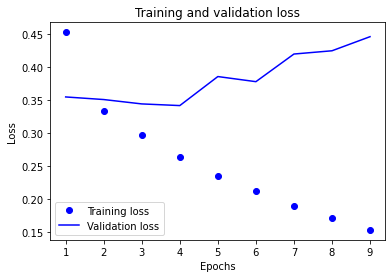

In [19]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

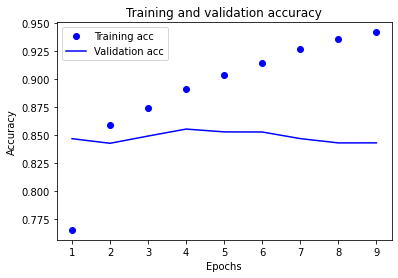

In [20]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 128)


In [22]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/lstm_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [23]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [24]:
word_vectors.similar_by_word("기술")

[('에이', 0.6642122864723206),
 ('여긴', 0.6262344121932983),
 ('이정재', 0.6163715124130249),
 ('버티', 0.6146203875541687),
 ('지능', 0.6084663271903992),
 ('관가', 0.6077626943588257),
 ('온통', 0.6077057123184204),
 ('자고', 0.6057048439979553),
 ('베드', 0.6043856739997864),
 ('허비', 0.6008208990097046)]

# 한국어 Word2Vec

In [25]:
ko_word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
ko_word2vec = gensim.models.Word2Vec.load(ko_word2vec_path)

In [26]:
ko_word2vec.similar_by_word("사랑")

/tmp/ipykernel_1719/2447483060.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  ko_word2vec.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [27]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [28]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec:
        embedding_matrix[i] = ko_word2vec[index_to_word[i]]

/tmp/ipykernel_1719/1899424056.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_word2vec:
/tmp/ipykernel_1719/1899424056.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_word2vec[index_to_word[i]]


In [29]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.LSTM(128))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [30]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_lstm_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [31]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 6s 11ms/step - loss: 0.5686 - accuracy: 0.6718 - val_loss: 0.4016 - val_accuracy: 0.8235

Epoch 00001: saving model to best_model_lstm_ko.h5
Epoch 2/20
376/376 [==============================] - 4s 10ms/step - loss: 0.3577 - accuracy: 0.8447 - val_loss: 0.3352 - val_accuracy: 0.8542

Epoch 00002: saving model to best_model_lstm_ko.h5
Epoch 3/20
376/376 [==============================] - 4s 11ms/step - loss: 0.2959 - accuracy: 0.8746 - val_loss: 0.3254 - val_accuracy: 0.8589

Epoch 00003: saving model to best_model_lstm_ko.h5
Epoch 4/20
376/376 [==============================] - 4s 11ms/step - loss: 0.2584 - accuracy: 0.8941 - val_loss: 0.3303 - val_accuracy: 0.8618

Epoch 00004: saving model to best_model_lstm_ko.h5
Epoch 5/20
376/376 [==============================] - 4s 11ms/step - loss: 0.2255 - accuracy: 0.9103 - val_loss: 0.3393 - val_accuracy: 0.8622

Epoch 00005: saving model to best_model_lstm_ko.h5
Epoch 6/20
376/376 [=====

In [32]:
loaded_model = load_model('best_model_lstm_ko.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4181 - accuracy: 0.8522
[0.41810983419418335, 0.852228581905365]


# 1-D CNN

In [33]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 64  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          28736     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [34]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_1dcnn.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [36]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 4s 6ms/step - loss: 0.4177 - accuracy: 0.7995 - val_loss: 0.3372 - val_accuracy: 0.8515

Epoch 00001: saving model to best_model_1dcnn.h5
Epoch 2/20
376/376 [==============================] - 2s 6ms/step - loss: 0.2899 - accuracy: 0.8808 - val_loss: 0.3257 - val_accuracy: 0.8599

Epoch 00002: saving model to best_model_1dcnn.h5
Epoch 3/20
376/376 [==============================] - 2s 6ms/step - loss: 0.2126 - accuracy: 0.9164 - val_loss: 0.3546 - val_accuracy: 0.8524

Epoch 00003: saving model to best_model_1dcnn.h5
Epoch 4/20
376/376 [==============================] - 2s 6ms/step - loss: 0.1281 - accuracy: 0.9543 - val_loss: 0.4344 - val_accuracy: 0.8452

Epoch 00004: saving model to best_model_1dcnn.h5
Epoch 5/20
376/376 [==============================] - 2s 6ms/step - loss: 0.0761 - accuracy: 0.9733 - val_loss: 0.5578 - val_accuracy: 0.8433

Epoch 00005: saving model to best_model_1dcnn.h5
Epoch 6/20
376/376 [====================

In [37]:
loaded_model = load_model('best_model_1dcnn.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.8072 - accuracy: 0.8352
[0.8072381615638733, 0.8351811766624451]


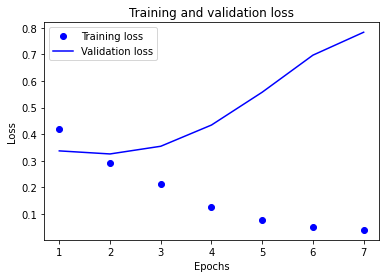

In [38]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

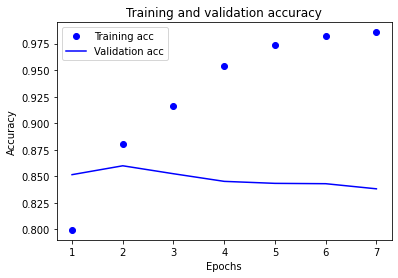

In [39]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [40]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 64)


In [41]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/1dcnn_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [42]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [43]:
word_vectors.similar_by_word("기술")

[('도망치', 0.445420503616333),
 ('떼', 0.4211033582687378),
 ('심해', 0.42067816853523254),
 ('조명', 0.41841912269592285),
 ('똘똘', 0.4076351225376129),
 ('도전', 0.40762367844581604),
 ('화법', 0.4022905230522156),
 ('돼지', 0.39974963665008545),
 ('94', 0.39871636033058167),
 ('무시무시', 0.39830532670021057)]

# 한국어 Word2Vec

In [44]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [45]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec:
        embedding_matrix[i] = ko_word2vec[index_to_word[i]]

/tmp/ipykernel_1719/1899424056.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_word2vec:
/tmp/ipykernel_1719/1899424056.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_word2vec[index_to_word[i]]


In [46]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(64, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 42, 64)            89664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [47]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_1dcnn_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [48]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 4s 8ms/step - loss: 0.5042 - accuracy: 0.7453 - val_loss: 0.4054 - val_accuracy: 0.8164

Epoch 00001: saving model to best_model_1dcnn_ko.h5
Epoch 2/20
376/376 [==============================] - 3s 7ms/step - loss: 0.3554 - accuracy: 0.8448 - val_loss: 0.3634 - val_accuracy: 0.8394

Epoch 00002: saving model to best_model_1dcnn_ko.h5
Epoch 3/20
376/376 [==============================] - 3s 8ms/step - loss: 0.2916 - accuracy: 0.8768 - val_loss: 0.3586 - val_accuracy: 0.8424

Epoch 00003: saving model to best_model_1dcnn_ko.h5
Epoch 4/20
376/376 [==============================] - 3s 8ms/step - loss: 0.2447 - accuracy: 0.8999 - val_loss: 0.3707 - val_accuracy: 0.8453

Epoch 00004: saving model to best_model_1dcnn_ko.h5
Epoch 5/20
376/376 [==============================] - 3s 8ms/step - loss: 0.2017 - accuracy: 0.9183 - val_loss: 0.4115 - val_accuracy: 0.8387

Epoch 00005: saving model to best_model_1dcnn_ko.h5
Epoch 6/20
376/376 [=====

In [49]:
loaded_model = load_model('best_model_1dcnn_ko.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6051 - accuracy: 0.8309
[0.6051028966903687, 0.8308684229850769]


## GlobalMaxPooling1D

In [50]:
vocab_size = 10000
word_vector_dim = 64


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          640000    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 640,529
Trainable params: 640,529
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [52]:
early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_gmp.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [53]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 2s 4ms/step - loss: 0.4677 - accuracy: 0.8053 - val_loss: 0.3537 - val_accuracy: 0.8452

Epoch 00001: saving model to best_model_gmp.h5
Epoch 2/20
376/376 [==============================] - 1s 4ms/step - loss: 0.3188 - accuracy: 0.8648 - val_loss: 0.3406 - val_accuracy: 0.8525

Epoch 00002: saving model to best_model_gmp.h5
Epoch 3/20
376/376 [==============================] - 1s 4ms/step - loss: 0.2702 - accuracy: 0.8893 - val_loss: 0.3467 - val_accuracy: 0.8519

Epoch 00003: saving model to best_model_gmp.h5
Epoch 4/20
376/376 [==============================] - 1s 4ms/step - loss: 0.2315 - accuracy: 0.9087 - val_loss: 0.3635 - val_accuracy: 0.8493

Epoch 00004: saving model to best_model_gmp.h5
Epoch 5/20
376/376 [==============================] - 1s 4ms/step - loss: 0.1963 - accuracy: 0.9256 - val_loss: 0.3871 - val_accuracy: 0.8463

Epoch 00005: saving model to best_model_gmp.h5
Epoch 6/20
376/376 [==============================

In [54]:
loaded_model = load_model('best_model_gmp.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4578 - accuracy: 0.8396
[0.45782914757728577, 0.8395955562591553]


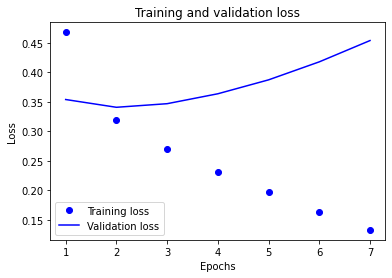

In [55]:
lstm_history_dict = lstm_history.history

acc = lstm_history_dict['accuracy']
val_acc = lstm_history_dict['val_accuracy']
loss = lstm_history_dict['loss']
val_loss = lstm_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

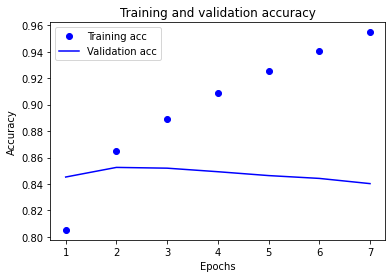

In [56]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [57]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 64)


In [58]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/gmp_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [59]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [60]:
word_vectors.similar_by_word("기술")

[('장르', 0.6409627199172974),
 ('X', 0.6187093257904053),
 ('상황', 0.5830190181732178),
 ('부부', 0.5771997570991516),
 ('2', 0.5746914148330688),
 ('아까운', 0.5669375658035278),
 ('짓', 0.5664169788360596),
 ('의지', 0.5595587491989136),
 ('늘어지', 0.5544605255126953),
 ('한계', 0.5535479187965393)]

## 한국어 Word2Vec

In [61]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

In [62]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_word2vec:
        embedding_matrix[i] = ko_word2vec[index_to_word[i]]

/tmp/ipykernel_1719/1899424056.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in ko_word2vec:
/tmp/ipykernel_1719/1899424056.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = ko_word2vec[index_to_word[i]]


In [63]:
# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 48, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
check = ModelCheckpoint('best_model_gmp_ko.h5', monitor='val_acc', mode='max', verbose=1, save_bast_only=True)

In [65]:
lstm_history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    callbacks=[early, check],
                    batch_size=256,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
376/376 [==============================] - 2s 5ms/step - loss: 0.6582 - accuracy: 0.6096 - val_loss: 0.5785 - val_accuracy: 0.7003

Epoch 00001: saving model to best_model_gmp_ko.h5
Epoch 2/20
376/376 [==============================] - 2s 5ms/step - loss: 0.5399 - accuracy: 0.7291 - val_loss: 0.5081 - val_accuracy: 0.7523

Epoch 00002: saving model to best_model_gmp_ko.h5
Epoch 3/20
376/376 [==============================] - 2s 5ms/step - loss: 0.4794 - accuracy: 0.7722 - val_loss: 0.4683 - val_accuracy: 0.7789

Epoch 00003: saving model to best_model_gmp_ko.h5
Epoch 4/20
376/376 [==============================] - 2s 5ms/step - loss: 0.4378 - accuracy: 0.7984 - val_loss: 0.4442 - val_accuracy: 0.7925

Epoch 00004: saving model to best_model_gmp_ko.h5
Epoch 5/20
376/376 [==============================] - 2s 5ms/step - loss: 0.4067 - accuracy: 0.8157 - val_loss: 0.4293 - val_accuracy: 0.8005

Epoch 00005: saving model to best_model_gmp_ko.h5
Epoch 6/20
376/376 [===============

In [66]:
loaded_model = load_model('best_model_gmp_ko.h5')
results = loaded_model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4240 - accuracy: 0.8197
[0.4240417182445526, 0.8197408318519592]


## 회고

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현
 - **3가지 이상의 모델이 성공적으로 시도됨**  
 - LSTM, 1-D CNN, GlobalMaxPooling1D
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석  
 - **gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함**  
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.  
 - **네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성**
 - LSTM + 한국어 Word2Vec -  accuracy : 0.85 